> ***For this project I will be using the libraries for data manipulation (Pandas, Numpy), data visualization (Matplotlib, Seaborn), machine learning (Scikit-learn).***

# > ***1. Load all necessary packages.***

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import metrics
from datetime import timedelta, datetime
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE 
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
%matplotlib inline

# > ***2. Preprocess Data to find out 'churned user'.***

> ***'churned user' is defined as users who have close_equity with below 10 dollars for consecutive 28 calendar days.***

In [2]:
equity_data = pd.read_csv('../input/robinhood-data/equity_value_data.csv') #Read equity dataset.

In [3]:
equity_data.head() #Take a look at the first 5 rows of the dataset.

,timestamp,close_equity,user_id
0,2016-11-16T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
1,2016-11-17T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
2,2016-11-18T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
3,2016-11-21T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
4,2016-11-22T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03


In [4]:
equity_data.info() #Check data type for each column of data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119158 entries, 0 to 1119157
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   timestamp     1119158 non-null  object 
 1   close_equity  1119158 non-null  float64
 2   user_id       1119158 non-null  object 
dtypes: float64(1), object(2)
memory usage: 25.6+ MB


In [5]:
equity_data.describe() #Check some statistical values of numerical columns.

,close_equity
count,1.119158e+06
mean,3.976953e+03
std,1.308590e+04
min,1.000000e+01
25%,1.115400e+02
50%,5.787400e+02
75%,2.564560e+03
max,4.789484e+05


> ***In order to find out churned users(below 10 dollars equity for 28 consecutive calenday days), we need to find out users that 1.have day difference of the current date and the previous date in the dataset, 2.have day difference between last date in the dataset and '2017-08-18', as the data was collected on '2017-08-18', given below 10 dollars equity days are not shown in the dataset. If the day difference is greater than or equal to 28, it means that there are 28 consecutive calendar days or longer when the users have less than 10 dollars in their equity.***

In [6]:
equity_data['date'] = [t.split('T')[0] for t in equity_data['timestamp']] #Only extract date, not time.
equity_data['date'] = pd.to_datetime(equity_data['date']) #Convert it into datetime type.
equity_data['collect_date'] = '2017-08-18' #When data was collected.
equity_data['collect_date'] = pd.to_datetime(equity_data['collect_date']) #Convert it into datetime type.

In [7]:
equity_data = equity_data.sort_values(by=['user_id', 'date']) #Ensure 'date' is in order for each user, for calculating day difference between the current date and the next date in the dataset.

In [8]:
churn_id = [] #Used to store user_id of churned users.
u_id = equity_data['user_id'].unique() #Used to store ALL user_id.
count = 0 #Used for debugging purposes

In [9]:
#Loop for each user and add churned users to 'churn_id'
for i in u_id: #Loop each user based on user_id.
    sub = equity_data[equity_data['user_id'] == i] # Dataset for the specific user.
    sub['last_trading_date'] = sub.date.shift(1) #Get the last trading day.
    sub = sub[sub['last_trading_date'].notnull()] #Filter out the first row for each user, which is null value, as its previous trading day is null.
    sub['diff'] = sub['date'] - sub['last_trading_date'] #Calculate the time difference of the current day and the previous trading day.
    sub['days_diff'] = [d.days for d in sub['diff']] #Convert it into 'days' granular level.
    sub['collect_date_diff'] = sub['collect_date'] - sub['date'] #The number of days between each date and collect_date.
    sub['days_collect_date_diff'] = [d.days for d in sub['collect_date_diff']] #Convert it into 'days' granular level.
    print(count) #for tracking process
    count = count + 1
    print('------------------------------------------------------------------') 
    for f in sub['days_collect_date_diff'][-1:]:
        if f >= 28:
            churn_id.append(i) #Add it into churn_id and save it because there are >= 28 days between the last date in the dataset and data collecting date for each user, which means there are >= 28 consecutive calenday days with below 10 dollar equity.
            print(i) #for debugging
            break #If finding out such a user, then break the current loop, continue and check the next user.
    continue
    for d in sub['days_diff']: #Start looping for each user to check if they have any day difference greater or equal to 28.
        if d > 28:
            churn_id.append(i) #Add it into churn_id and save it.
            print(i) #for debugging
            break #If it finds a pair of 2 consecutive days in the dataset with day difference larger than or equal to 28 for a user, then break the loop and go to the next user.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0
------------------------------------------------------------------
1
------------------------------------------------------------------
2
------------------------------------------------------------------
3
------------------------------------------------------------------
4
------------------------------------------------------------------
5
------------------------------------------------------------------
6
------------------------------------------------------------------
004aab1640f3a04b87b1f404fb4c018d
7
------------------------------------------------------------------
004ea9d7662aa8dc840bbff212cfa4b8
8
------------------------------------------------------------------
9
------------------------------------------------------------------
10
------------------------------------------------------------------
11
------------------------------------------------------------------
12
------------------------------------------------------------------
13
-------------------------------

112
------------------------------------------------------------------
056f2bce1aca9b0679e7146134f01f92
113
------------------------------------------------------------------
114
------------------------------------------------------------------
115
------------------------------------------------------------------
116
------------------------------------------------------------------
117
------------------------------------------------------------------
118
------------------------------------------------------------------
119
------------------------------------------------------------------
120
------------------------------------------------------------------
121
------------------------------------------------------------------
122
------------------------------------------------------------------
05e8696965c7bbf4db5e53b505eab8b4
123
------------------------------------------------------------------
124
------------------------------------------------------------------
125
-------

221
------------------------------------------------------------------
222
------------------------------------------------------------------
223
------------------------------------------------------------------
224
------------------------------------------------------------------
225
------------------------------------------------------------------
226
------------------------------------------------------------------
227
------------------------------------------------------------------
228
------------------------------------------------------------------
0b05f8d83e97ac57867fe87a2437b21f
229
------------------------------------------------------------------
230
------------------------------------------------------------------
0b394cd74a8b89e6a38440b953c58363
231
------------------------------------------------------------------
232
------------------------------------------------------------------
0b40f2c065c081c8e0f828f73d892d51
233
---------------------------------------------

327
------------------------------------------------------------------
0f8a50f75bd1a7053c945b17bc863712
328
------------------------------------------------------------------
329
------------------------------------------------------------------
330
------------------------------------------------------------------
331
------------------------------------------------------------------
0fc11b794da5e2cf1bd61255d6e33f4c
332
------------------------------------------------------------------
333
------------------------------------------------------------------
334
------------------------------------------------------------------
335
------------------------------------------------------------------
336
------------------------------------------------------------------
337
------------------------------------------------------------------
338
------------------------------------------------------------------
339
------------------------------------------------------------------
340
-------

436
------------------------------------------------------------------
14a58a99d496294b1b5d4922ae01159d
437
------------------------------------------------------------------
14a9a2a99a4d42655ad6e331b35acab6
438
------------------------------------------------------------------
439
------------------------------------------------------------------
440
------------------------------------------------------------------
14bd9c4df177b95f9589d5b3d801c5ea
441
------------------------------------------------------------------
442
------------------------------------------------------------------
443
------------------------------------------------------------------
444
------------------------------------------------------------------
445
------------------------------------------------------------------
446
------------------------------------------------------------------
447
------------------------------------------------------------------
448
---------------------------------------------

547
------------------------------------------------------------------
548
------------------------------------------------------------------
549
------------------------------------------------------------------
19692da524c0ccbb64017a68e7bfb27e
550
------------------------------------------------------------------
551
------------------------------------------------------------------
552
------------------------------------------------------------------
553
------------------------------------------------------------------
554
------------------------------------------------------------------
198d9b28abbd28bb1e96535599e34012
555
------------------------------------------------------------------
556
------------------------------------------------------------------
557
------------------------------------------------------------------
558
------------------------------------------------------------------
559
------------------------------------------------------------------
19d05587b5b

656
------------------------------------------------------------------
657
------------------------------------------------------------------
658
------------------------------------------------------------------
659
------------------------------------------------------------------
660
------------------------------------------------------------------
1e7c09df3318894ba64a3652c98d7b94
661
------------------------------------------------------------------
662
------------------------------------------------------------------
663
------------------------------------------------------------------
664
------------------------------------------------------------------
665
------------------------------------------------------------------
666
------------------------------------------------------------------
667
------------------------------------------------------------------
668
------------------------------------------------------------------
669
----------------------------------------

767
------------------------------------------------------------------
768
------------------------------------------------------------------
769
------------------------------------------------------------------
770
------------------------------------------------------------------
771
------------------------------------------------------------------
772
------------------------------------------------------------------
246e7d080140008e7eddd702c6a5b4d5
773
------------------------------------------------------------------
774
------------------------------------------------------------------
247fe2595cbe48a503c4c83251a7f17a
775
------------------------------------------------------------------
776
------------------------------------------------------------------
777
------------------------------------------------------------------
778
------------------------------------------------------------------
779
------------------------------------------------------------------
780
-------

875
------------------------------------------------------------------
876
------------------------------------------------------------------
877
------------------------------------------------------------------
878
------------------------------------------------------------------
879
------------------------------------------------------------------
29632bdb59461f00fbbaff0876d4c0fe
880
------------------------------------------------------------------
881
------------------------------------------------------------------
882
------------------------------------------------------------------
883
------------------------------------------------------------------
884
------------------------------------------------------------------
885
------------------------------------------------------------------
886
------------------------------------------------------------------
887
------------------------------------------------------------------
888
----------------------------------------

984
------------------------------------------------------------------
985
------------------------------------------------------------------
986
------------------------------------------------------------------
987
------------------------------------------------------------------
988
------------------------------------------------------------------
2dfbc8a05deb2c6f415a80de39896e3a
989
------------------------------------------------------------------
990
------------------------------------------------------------------
991
------------------------------------------------------------------
992
------------------------------------------------------------------
993
------------------------------------------------------------------
994
------------------------------------------------------------------
2e23ee4c67f9fd4ddb620b86526a8b37
995
------------------------------------------------------------------
996
------------------------------------------------------------------
2e50103046a

1092
------------------------------------------------------------------
1093
------------------------------------------------------------------
1094
------------------------------------------------------------------
1095
------------------------------------------------------------------
1096
------------------------------------------------------------------
32b8547296a2c929ef095b5c5212b585
1097
------------------------------------------------------------------
1098
------------------------------------------------------------------
32d3e97a9b1313a90f896398e29f64db
1099
------------------------------------------------------------------
1100
------------------------------------------------------------------
1101
------------------------------------------------------------------
1102
------------------------------------------------------------------
1103
------------------------------------------------------------------
1104
-----------------------------------------------------------------

1198
------------------------------------------------------------------
37c1b4b9b536e2459db54c383d060d97
1199
------------------------------------------------------------------
37c4c0e2dd8a7a5f2d61306b6dbdb258
1200
------------------------------------------------------------------
1201
------------------------------------------------------------------
37f6a9cdbb7d358170c3ba6ac97dbff8
1202
------------------------------------------------------------------
1203
------------------------------------------------------------------
1204
------------------------------------------------------------------
1205
------------------------------------------------------------------
38195e2a4838bff7fed7bd3297194bf3
1206
------------------------------------------------------------------
1207
------------------------------------------------------------------
1208
------------------------------------------------------------------
1209
------------------------------------------------------------------
1210

1302
------------------------------------------------------------------
1303
------------------------------------------------------------------
1304
------------------------------------------------------------------
3c4349057d2bd7c5fe5505f5ff127d9b
1305
------------------------------------------------------------------
1306
------------------------------------------------------------------
1307
------------------------------------------------------------------
1308
------------------------------------------------------------------
1309
------------------------------------------------------------------
1310
------------------------------------------------------------------
1311
------------------------------------------------------------------
1312
------------------------------------------------------------------
1313
------------------------------------------------------------------
1314
------------------------------------------------------------------
1315
--------------------------

1412
------------------------------------------------------------------
1413
------------------------------------------------------------------
1414
------------------------------------------------------------------
1415
------------------------------------------------------------------
1416
------------------------------------------------------------------
40f37d5709b1f15a5b9c5bd9eddf0659
1417
------------------------------------------------------------------
1418
------------------------------------------------------------------
1419
------------------------------------------------------------------
1420
------------------------------------------------------------------
1421
------------------------------------------------------------------
1422
------------------------------------------------------------------
1423
------------------------------------------------------------------
416f240ebb7242226caba938452fb29d
1424
-----------------------------------------------------------------

1519
------------------------------------------------------------------
1520
------------------------------------------------------------------
1521
------------------------------------------------------------------
1522
------------------------------------------------------------------
1523
------------------------------------------------------------------
1524
------------------------------------------------------------------
1525
------------------------------------------------------------------
1526
------------------------------------------------------------------
1527
------------------------------------------------------------------
1528
------------------------------------------------------------------
1529
------------------------------------------------------------------
1530
------------------------------------------------------------------
1531
------------------------------------------------------------------
1532
-----------------------------------------------------------

1629
------------------------------------------------------------------
1630
------------------------------------------------------------------
1631
------------------------------------------------------------------
1632
------------------------------------------------------------------
1633
------------------------------------------------------------------
1634
------------------------------------------------------------------
1635
------------------------------------------------------------------
1636
------------------------------------------------------------------
1637
------------------------------------------------------------------
1638
------------------------------------------------------------------
1639
------------------------------------------------------------------
1640
------------------------------------------------------------------
1641
------------------------------------------------------------------
1642
-----------------------------------------------------------

1739
------------------------------------------------------------------
1740
------------------------------------------------------------------
1741
------------------------------------------------------------------
1742
------------------------------------------------------------------
1743
------------------------------------------------------------------
1744
------------------------------------------------------------------
1745
------------------------------------------------------------------
1746
------------------------------------------------------------------
1747
------------------------------------------------------------------
1748
------------------------------------------------------------------
1749
------------------------------------------------------------------
1750
------------------------------------------------------------------
1751
------------------------------------------------------------------
1752
-----------------------------------------------------------

1845
------------------------------------------------------------------
1846
------------------------------------------------------------------
1847
------------------------------------------------------------------
1848
------------------------------------------------------------------
1849
------------------------------------------------------------------
1850
------------------------------------------------------------------
555b95a8ed430fb303aa0756c343b7e6
1851
------------------------------------------------------------------
1852
------------------------------------------------------------------
1853
------------------------------------------------------------------
1854
------------------------------------------------------------------
1855
------------------------------------------------------------------
1856
------------------------------------------------------------------
1857
------------------------------------------------------------------
1858
--------------------------

1954
------------------------------------------------------------------
1955
------------------------------------------------------------------
1956
------------------------------------------------------------------
1957
------------------------------------------------------------------
1958
------------------------------------------------------------------
1959
------------------------------------------------------------------
1960
------------------------------------------------------------------
1961
------------------------------------------------------------------
1962
------------------------------------------------------------------
1963
------------------------------------------------------------------
1964
------------------------------------------------------------------
1965
------------------------------------------------------------------
1966
------------------------------------------------------------------
1967
-----------------------------------------------------------

2062
------------------------------------------------------------------
2063
------------------------------------------------------------------
5e4eab3fad49b4f36b3bb6375c2521e1
2064
------------------------------------------------------------------
2065
------------------------------------------------------------------
2066
------------------------------------------------------------------
5e861b672a01b08431c2ad1e21819a58
2067
------------------------------------------------------------------
2068
------------------------------------------------------------------
2069
------------------------------------------------------------------
2070
------------------------------------------------------------------
2071
------------------------------------------------------------------
2072
------------------------------------------------------------------
5eb7e5244d0e33ce744fbe2d530b9c75
2073
------------------------------------------------------------------
5ec6ca233186e580d1a9d9b7164ac649
2074

2167
------------------------------------------------------------------
2168
------------------------------------------------------------------
2169
------------------------------------------------------------------
2170
------------------------------------------------------------------
63ccce12a09c4bfdace2e7c024d06095
2171
------------------------------------------------------------------
2172
------------------------------------------------------------------
2173
------------------------------------------------------------------
2174
------------------------------------------------------------------
2175
------------------------------------------------------------------
2176
------------------------------------------------------------------
2177
------------------------------------------------------------------
2178
------------------------------------------------------------------
2179
------------------------------------------------------------------
2180
--------------------------

2277
------------------------------------------------------------------
2278
------------------------------------------------------------------
2279
------------------------------------------------------------------
2280
------------------------------------------------------------------
2281
------------------------------------------------------------------
2282
------------------------------------------------------------------
2283
------------------------------------------------------------------
2284
------------------------------------------------------------------
2285
------------------------------------------------------------------
2286
------------------------------------------------------------------
2287
------------------------------------------------------------------
2288
------------------------------------------------------------------
2289
------------------------------------------------------------------
2290
-----------------------------------------------------------

2385
------------------------------------------------------------------
2386
------------------------------------------------------------------
2387
------------------------------------------------------------------
2388
------------------------------------------------------------------
6e6d5c958e82438989b28ea550eb6aba
2389
------------------------------------------------------------------
2390
------------------------------------------------------------------
2391
------------------------------------------------------------------
2392
------------------------------------------------------------------
2393
------------------------------------------------------------------
2394
------------------------------------------------------------------
6e9eabf041c5fa517dc5fb0b38410cc3
2395
------------------------------------------------------------------
2396
------------------------------------------------------------------
6eb0c714ddfb680758a580d02116f703
2397
--------------------------------

2492
------------------------------------------------------------------
2493
------------------------------------------------------------------
2494
------------------------------------------------------------------
7334d064dff7e06735205f6fa75a23fd
2495
------------------------------------------------------------------
2496
------------------------------------------------------------------
735163b197cd88e7d08e6b5951a7bbf7
2497
------------------------------------------------------------------
2498
------------------------------------------------------------------
2499
------------------------------------------------------------------
2500
------------------------------------------------------------------
2501
------------------------------------------------------------------
2502
------------------------------------------------------------------
7396c4fa549a1b58241df9a5dc6be3e0
2503
------------------------------------------------------------------
2504
--------------------------------

2597
------------------------------------------------------------------
2598
------------------------------------------------------------------
2599
------------------------------------------------------------------
2600
------------------------------------------------------------------
2601
------------------------------------------------------------------
2602
------------------------------------------------------------------
2603
------------------------------------------------------------------
788a96c694de228a433d6f89dbccc234
2604
------------------------------------------------------------------
2605
------------------------------------------------------------------
2606
------------------------------------------------------------------
78b6a57be1c1c8547ebdf315ad45e6ba
2607
------------------------------------------------------------------
2608
------------------------------------------------------------------
78d1e52ac8d932384e7b3ca53f43a268
2609
--------------------------------

2709
------------------------------------------------------------------
2710
------------------------------------------------------------------
7dcebb69a2c36c97d8f65571937edf38
2711
------------------------------------------------------------------
2712
------------------------------------------------------------------
7dd4f135677e0ae34be0bab28ce764d3
2713
------------------------------------------------------------------
2714
------------------------------------------------------------------
2715
------------------------------------------------------------------
2716
------------------------------------------------------------------
2717
------------------------------------------------------------------
2718
------------------------------------------------------------------
2719
------------------------------------------------------------------
2720
------------------------------------------------------------------
2721
-----------------------------------------------------------------

2816
------------------------------------------------------------------
2817
------------------------------------------------------------------
2818
------------------------------------------------------------------
2819
------------------------------------------------------------------
2820
------------------------------------------------------------------
2821
------------------------------------------------------------------
2822
------------------------------------------------------------------
2823
------------------------------------------------------------------
2824
------------------------------------------------------------------
2825
------------------------------------------------------------------
2826
------------------------------------------------------------------
2827
------------------------------------------------------------------
2828
------------------------------------------------------------------
2829
-----------------------------------------------------------

2926
------------------------------------------------------------------
2927
------------------------------------------------------------------
2928
------------------------------------------------------------------
2929
------------------------------------------------------------------
2930
------------------------------------------------------------------
2931
------------------------------------------------------------------
2932
------------------------------------------------------------------
2933
------------------------------------------------------------------
2934
------------------------------------------------------------------
2935
------------------------------------------------------------------
2936
------------------------------------------------------------------
2937
------------------------------------------------------------------
2938
------------------------------------------------------------------
2939
-----------------------------------------------------------

3035
------------------------------------------------------------------
3036
------------------------------------------------------------------
3037
------------------------------------------------------------------
3038
------------------------------------------------------------------
3039
------------------------------------------------------------------
3040
------------------------------------------------------------------
3041
------------------------------------------------------------------
3042
------------------------------------------------------------------
3043
------------------------------------------------------------------
3044
------------------------------------------------------------------
3045
------------------------------------------------------------------
3046
------------------------------------------------------------------
8c9bdddd55ed77b40fb7a53f439bbfab
3047
------------------------------------------------------------------
3048
--------------------------

3143
------------------------------------------------------------------
3144
------------------------------------------------------------------
9121bbdb811bcb10de9b6f85b2b5e458
3145
------------------------------------------------------------------
3146
------------------------------------------------------------------
3147
------------------------------------------------------------------
3148
------------------------------------------------------------------
3149
------------------------------------------------------------------
3150
------------------------------------------------------------------
916c78079da9540124f33f12bfa8ed7e
3151
------------------------------------------------------------------
3152
------------------------------------------------------------------
9179dcec798de0ccbb2351fd0ecd0b7b
3153
------------------------------------------------------------------
3154
------------------------------------------------------------------
3155
--------------------------------

3249
------------------------------------------------------------------
3250
------------------------------------------------------------------
3251
------------------------------------------------------------------
95ac58a75c034721b0ebadfce9f591b3
3252
------------------------------------------------------------------
3253
------------------------------------------------------------------
3254
------------------------------------------------------------------
3255
------------------------------------------------------------------
3256
------------------------------------------------------------------
961291c1856a5ca7ce8342c82ad14278
3257
------------------------------------------------------------------
3258
------------------------------------------------------------------
3259
------------------------------------------------------------------
3260
------------------------------------------------------------------
3261
-----------------------------------------------------------------

3357
------------------------------------------------------------------
3358
------------------------------------------------------------------
3359
------------------------------------------------------------------
3360
------------------------------------------------------------------
3361
------------------------------------------------------------------
9a8276375c542f63a38c8c58e63de741
3362
------------------------------------------------------------------
3363
------------------------------------------------------------------
3364
------------------------------------------------------------------
3365
------------------------------------------------------------------
3366
------------------------------------------------------------------
3367
------------------------------------------------------------------
3368
------------------------------------------------------------------
9b090ef6fc85ca988a9bf540f98a73c2
3369
-----------------------------------------------------------------

3466
------------------------------------------------------------------
3467
------------------------------------------------------------------
3468
------------------------------------------------------------------
3469
------------------------------------------------------------------
3470
------------------------------------------------------------------
3471
------------------------------------------------------------------
3472
------------------------------------------------------------------
3473
------------------------------------------------------------------
3474
------------------------------------------------------------------
3475
------------------------------------------------------------------
3476
------------------------------------------------------------------
3477
------------------------------------------------------------------
3478
------------------------------------------------------------------
3479
-----------------------------------------------------------

3574
------------------------------------------------------------------
3575
------------------------------------------------------------------
3576
------------------------------------------------------------------
3577
------------------------------------------------------------------
3578
------------------------------------------------------------------
3579
------------------------------------------------------------------
3580
------------------------------------------------------------------
3581
------------------------------------------------------------------
3582
------------------------------------------------------------------
3583
------------------------------------------------------------------
3584
------------------------------------------------------------------
3585
------------------------------------------------------------------
a541737b5ce39d1cac27952aae426b03
3586
------------------------------------------------------------------
a54d828f4765059bedeea792734f66d

3680
------------------------------------------------------------------
a9949e7dcc18090dfc1ba770b80a965a
3681
------------------------------------------------------------------
3682
------------------------------------------------------------------
3683
------------------------------------------------------------------
3684
------------------------------------------------------------------
3685
------------------------------------------------------------------
3686
------------------------------------------------------------------
3687
------------------------------------------------------------------
3688
------------------------------------------------------------------
3689
------------------------------------------------------------------
3690
------------------------------------------------------------------
3691
------------------------------------------------------------------
3692
------------------------------------------------------------------
3693
--------------------------

3788
------------------------------------------------------------------
3789
------------------------------------------------------------------
3790
------------------------------------------------------------------
3791
------------------------------------------------------------------
3792
------------------------------------------------------------------
3793
------------------------------------------------------------------
3794
------------------------------------------------------------------
aee0fa4a5a283eb262ce1cfe613e610b
3795
------------------------------------------------------------------
3796
------------------------------------------------------------------
3797
------------------------------------------------------------------
3798
------------------------------------------------------------------
3799
------------------------------------------------------------------
af1b69efbfe97b2d1a1fc168cfc28fd6
3800
-----------------------------------------------------------------

3899
------------------------------------------------------------------
3900
------------------------------------------------------------------
b46326641302e18253dc38ce40750844
3901
------------------------------------------------------------------
3902
------------------------------------------------------------------
3903
------------------------------------------------------------------
3904
------------------------------------------------------------------
3905
------------------------------------------------------------------
3906
------------------------------------------------------------------
3907
------------------------------------------------------------------
3908
------------------------------------------------------------------
3909
------------------------------------------------------------------
3910
------------------------------------------------------------------
3911
------------------------------------------------------------------
3912
--------------------------

4007
------------------------------------------------------------------
4008
------------------------------------------------------------------
4009
------------------------------------------------------------------
4010
------------------------------------------------------------------
4011
------------------------------------------------------------------
4012
------------------------------------------------------------------
b8eca81364d77ae1cbd93a1faa7e62f5
4013
------------------------------------------------------------------
b8ed8e073374b72ed0cafe0b5dca11cc
4014
------------------------------------------------------------------
4015
------------------------------------------------------------------
4016
------------------------------------------------------------------
4017
------------------------------------------------------------------
4018
------------------------------------------------------------------
4019
-----------------------------------------------------------------

4114
------------------------------------------------------------------
4115
------------------------------------------------------------------
4116
------------------------------------------------------------------
be4644c41e11fcadac490d1109d772a8
4117
------------------------------------------------------------------
4118
------------------------------------------------------------------
4119
------------------------------------------------------------------
be5790e6370fa680756531d7cb963421
4120
------------------------------------------------------------------
4121
------------------------------------------------------------------
4122
------------------------------------------------------------------
4123
------------------------------------------------------------------
4124
------------------------------------------------------------------
4125
------------------------------------------------------------------
4126
-----------------------------------------------------------------

4221
------------------------------------------------------------------
4222
------------------------------------------------------------------
4223
------------------------------------------------------------------
4224
------------------------------------------------------------------
c3955d83c8ae78fcd9a7bef1035fb689
4225
------------------------------------------------------------------
4226
------------------------------------------------------------------
4227
------------------------------------------------------------------
4228
------------------------------------------------------------------
4229
------------------------------------------------------------------
4230
------------------------------------------------------------------
c3d962908b44e3c16c329091a60a4061
4231
------------------------------------------------------------------
4232
------------------------------------------------------------------
4233
-----------------------------------------------------------------

4329
------------------------------------------------------------------
c7b204bd66d6ba6869dbad462a4a712b
4330
------------------------------------------------------------------
4331
------------------------------------------------------------------
4332
------------------------------------------------------------------
4333
------------------------------------------------------------------
4334
------------------------------------------------------------------
4335
------------------------------------------------------------------
4336
------------------------------------------------------------------
4337
------------------------------------------------------------------
4338
------------------------------------------------------------------
4339
------------------------------------------------------------------
4340
------------------------------------------------------------------
c7f5495062e7ac8f763a4fa1d41893bd
4341
-----------------------------------------------------------------

4436
------------------------------------------------------------------
4437
------------------------------------------------------------------
4438
------------------------------------------------------------------
cc7531d3e9cd708d317f76fe97a881cc
4439
------------------------------------------------------------------
cc7cb21b06b09da7befcd72b89d47475
4440
------------------------------------------------------------------
4441
------------------------------------------------------------------
4442
------------------------------------------------------------------
4443
------------------------------------------------------------------
cd00effd01acada2388c5be4f2c48288
4444
------------------------------------------------------------------
4445
------------------------------------------------------------------
4446
------------------------------------------------------------------
4447
------------------------------------------------------------------
cd44cc9e303c549ac5e610fd072db9af
4448

4542
------------------------------------------------------------------
4543
------------------------------------------------------------------
4544
------------------------------------------------------------------
d118f450d276c72078354ed9565c06ce
4545
------------------------------------------------------------------
4546
------------------------------------------------------------------
4547
------------------------------------------------------------------
d173e22f522422d9c4bc8a0a6553680a
4548
------------------------------------------------------------------
4549
------------------------------------------------------------------
4550
------------------------------------------------------------------
4551
------------------------------------------------------------------
4552
------------------------------------------------------------------
4553
------------------------------------------------------------------
d1a734cd951016a6130bb018e505fbbd
4554
--------------------------------

4649
------------------------------------------------------------------
4650
------------------------------------------------------------------
4651
------------------------------------------------------------------
4652
------------------------------------------------------------------
4653
------------------------------------------------------------------
4654
------------------------------------------------------------------
4655
------------------------------------------------------------------
4656
------------------------------------------------------------------
4657
------------------------------------------------------------------
4658
------------------------------------------------------------------
4659
------------------------------------------------------------------
d602d8ffaf6dc58d6a413bd665dbc020
4660
------------------------------------------------------------------
4661
------------------------------------------------------------------
4662
--------------------------

4757
------------------------------------------------------------------
4758
------------------------------------------------------------------
4759
------------------------------------------------------------------
4760
------------------------------------------------------------------
4761
------------------------------------------------------------------
4762
------------------------------------------------------------------
4763
------------------------------------------------------------------
4764
------------------------------------------------------------------
4765
------------------------------------------------------------------
4766
------------------------------------------------------------------
4767
------------------------------------------------------------------
4768
------------------------------------------------------------------
4769
------------------------------------------------------------------
4770
-----------------------------------------------------------

4865
------------------------------------------------------------------
4866
------------------------------------------------------------------
4867
------------------------------------------------------------------
4868
------------------------------------------------------------------
4869
------------------------------------------------------------------
4870
------------------------------------------------------------------
4871
------------------------------------------------------------------
de8e8df4693a3cb445be2911bd64777b
4872
------------------------------------------------------------------
4873
------------------------------------------------------------------
4874
------------------------------------------------------------------
4875
------------------------------------------------------------------
4876
------------------------------------------------------------------
4877
------------------------------------------------------------------
4878
--------------------------

4973
------------------------------------------------------------------
4974
------------------------------------------------------------------
4975
------------------------------------------------------------------
e40991f1a148fb2972a5a570e9b51f35
4976
------------------------------------------------------------------
4977
------------------------------------------------------------------
4978
------------------------------------------------------------------
4979
------------------------------------------------------------------
e44fe6699c45f09c3810f8c7842f94c5
4980
------------------------------------------------------------------
4981
------------------------------------------------------------------
4982
------------------------------------------------------------------
4983
------------------------------------------------------------------
4984
------------------------------------------------------------------
4985
-----------------------------------------------------------------

5079
------------------------------------------------------------------
5080
------------------------------------------------------------------
5081
------------------------------------------------------------------
e9314be4a871b7522072448baae0ec07
5082
------------------------------------------------------------------
5083
------------------------------------------------------------------
5084
------------------------------------------------------------------
5085
------------------------------------------------------------------
5086
------------------------------------------------------------------
e94ecb13e405e0b7d76d28edbd68145d
5087
------------------------------------------------------------------
5088
------------------------------------------------------------------
5089
------------------------------------------------------------------
5090
------------------------------------------------------------------
e98d528a39224f847c16b1a42cbd083e
5091
--------------------------------

5188
------------------------------------------------------------------
ed90ef3a292b59336316f55d464df183
5189
------------------------------------------------------------------
5190
------------------------------------------------------------------
5191
------------------------------------------------------------------
5192
------------------------------------------------------------------
5193
------------------------------------------------------------------
5194
------------------------------------------------------------------
5195
------------------------------------------------------------------
5196
------------------------------------------------------------------
5197
------------------------------------------------------------------
5198
------------------------------------------------------------------
5199
------------------------------------------------------------------
5200
------------------------------------------------------------------
5201
--------------------------

5297
------------------------------------------------------------------
5298
------------------------------------------------------------------
5299
------------------------------------------------------------------
5300
------------------------------------------------------------------
5301
------------------------------------------------------------------
5302
------------------------------------------------------------------
5303
------------------------------------------------------------------
5304
------------------------------------------------------------------
5305
------------------------------------------------------------------
5306
------------------------------------------------------------------
f2dfdb6eccb56f5da401fb34ae4deca4
5307
------------------------------------------------------------------
5308
------------------------------------------------------------------
5309
------------------------------------------------------------------
5310
--------------------------

5405
------------------------------------------------------------------
5406
------------------------------------------------------------------
5407
------------------------------------------------------------------
5408
------------------------------------------------------------------
5409
------------------------------------------------------------------
5410
------------------------------------------------------------------
f7c85aae5a11ca41458f7422527a3721
5411
------------------------------------------------------------------
5412
------------------------------------------------------------------
5413
------------------------------------------------------------------
5414
------------------------------------------------------------------
5415
------------------------------------------------------------------
5416
------------------------------------------------------------------
5417
------------------------------------------------------------------
f7f1cdc69c7c7ad6558f7b75847818b

5512
------------------------------------------------------------------
5513
------------------------------------------------------------------
5514
------------------------------------------------------------------
5515
------------------------------------------------------------------
5516
------------------------------------------------------------------
5517
------------------------------------------------------------------
5518
------------------------------------------------------------------
5519
------------------------------------------------------------------
5520
------------------------------------------------------------------
5521
------------------------------------------------------------------
5522
------------------------------------------------------------------
5523
------------------------------------------------------------------
5524
------------------------------------------------------------------
5525
-----------------------------------------------------------

In [10]:
len(churn_id) #Check the number of churned users.

810

> ***Question a): The percentage of users have churned in the data provided is:***

In [11]:
len(churn_id) / len(equity_data.user_id.unique()) * 100

14.505730659025787

In [12]:
(len(equity_data.user_id.unique()) - len(churn_id)) / len(equity_data.user_id.unique()) * 100
(len(equity_data.user_id.unique()) - len(churn_id)) / len(churn_id) 

5.893827160493827

> ***The ratio of unchurned users and churned users is about 6 : 1, which is an imbalanced dataset. We will address it before modeling stage.***

> ***Note: User can be churned for different reasons. Let us look at some of their statistical values and then categorize them based on possible reasons.
> After exploring some of them, I can simply categorize them into 3 categories:***

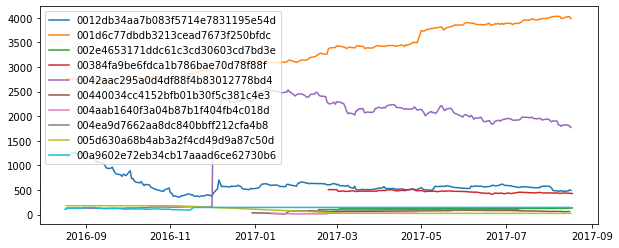

In [13]:
# df = equity_data[equity_data['user_id'].isin(u_id[:10])]
# fig, ax = plt.subplots(figsize=(10,4))
# #for k, set in df.groupby('xx')...then k is 'xxx', set is the groupby result.
# for key, user in df.groupby('user_id'): #iterative
#     ax.plot(user['date'], user['close_equity'], label=key)
# ax.legend()
# plt.show()

user_id
0012db34aa7b083f5714e7831195e54d    AxesSubplot(0.125,0.2;0.775x0.68)
001d6c77dbdb3213cead7673f250bfdc    AxesSubplot(0.125,0.2;0.775x0.68)
002e4653171ddc61c3cd30603cd7bd3e    AxesSubplot(0.125,0.2;0.775x0.68)
00384fa9be6fdca1b786bae70d78f88f    AxesSubplot(0.125,0.2;0.775x0.68)
0042aac295a0d4df88f4b83012778bd4    AxesSubplot(0.125,0.2;0.775x0.68)
Name: close_equity, dtype: object

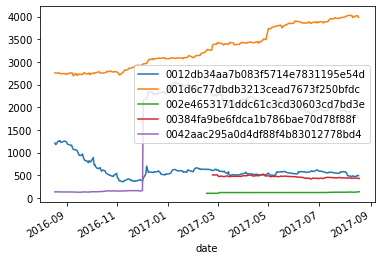

In [14]:
# df = equity_data[equity_data['user_id'].isin(u_id[:5])]
# df.set_index('date', inplace=True)
# df.groupby('user_id')['close_equity'].plot(legend=True)

user_id
0012db34aa7b083f5714e7831195e54d    AxesSubplot(0.125,0.2;0.775x0.68)
001d6c77dbdb3213cead7673f250bfdc    AxesSubplot(0.125,0.2;0.775x0.68)
002e4653171ddc61c3cd30603cd7bd3e    AxesSubplot(0.125,0.2;0.775x0.68)
00384fa9be6fdca1b786bae70d78f88f    AxesSubplot(0.125,0.2;0.775x0.68)
0042aac295a0d4df88f4b83012778bd4    AxesSubplot(0.125,0.2;0.775x0.68)
dtype: object

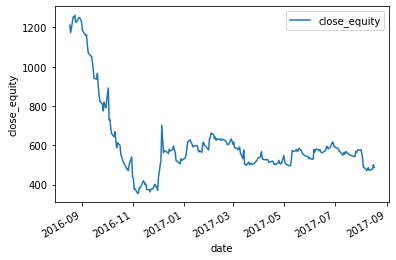

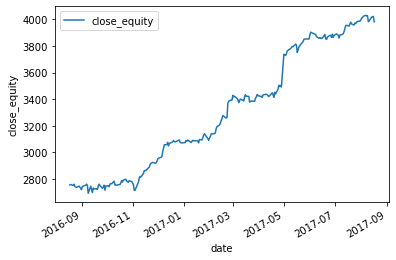

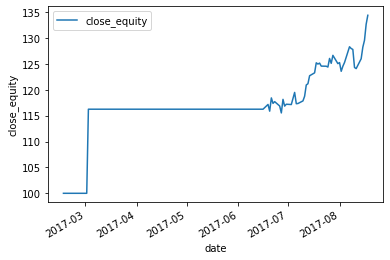

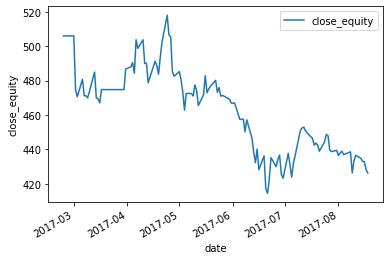

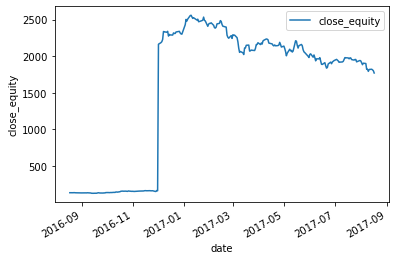

In [16]:
# equity_data[equity_data['user_id'].isin(u_id[:5])].groupby('user_id').plot(x='date', y='close_equity', xlabel='date', ylabel='close_equity')

In [ ]:
# #Operate for the new feature: 'equity_shape'
# e_decreasing = []
# ii = 0
# for i in u_id:
#     sub = equity_data[equity_data['user_id'] == i]
#     sub['rolling_7'] = sub['close_equity'].rolling(7).mean() # 7 day window
#     #shift 1 day 
#     sub['rolling_7_1'] = sub['rolling_7'].shift(1)
#     sub['diff'] = sub['rolling_7'] - sub['rolling_7_1']
#     index = 0
#     print(ii)
#     ii = ii + 1
#     for idx in sub['diff']:
#         if idx <= 0:
#             index = index+1
#         else:
#             index=0
#         if index == 28: #continuous 15 days 
#             e_decreasing.append(i)
#             print(i)
#             break

In [ ]:
# equity_data['equity_shape'] = equity_data

In [ ]:
#Define a new feature: equity_shape
#1. Periodical Stable: p_stable
#continuous 15 days -> if the standard deviation is < 2, then define the user as 'p_stable'
#2. 10 Dollar Around: 10_around
#If there is 10 continuous days with equity_value < 13, then define is as '10_around'
#3. Equity Decreasing: e_decreasing
#If 5 day average equity keeps decreasing for 7 days, then define it as 'e_decreasing'
#4. Money Out: m_out
#If 10 day average equity keeps increasing for 7 days, then define it as 'm_out'
#5. Others
#If it does not belong to the first 4 categories, then it belongs to 'others'.

> ***1. Periodical Stable: this kind of churned users tend to have stable equity in some period of time and it varies for other periods of time. This may be due to they get free stock once joining RobinHood, or they get refer bonus or they never transfer money into their account.That is why we see the graph like below. (In this case, we need to check the relationship among 'investment_experience', 'risk_tolerance' and ect.).***

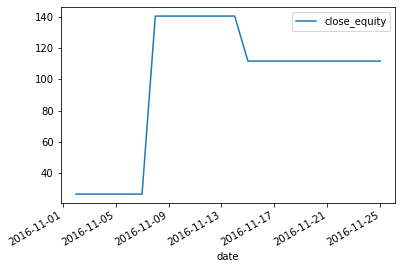

In [17]:
equity_data[equity_data['user_id'] == churn_id[12]].plot(x='date', y='close_equity')

> ***2. 10 Dollar Around: This type of churned users have equity around 10 dollars, like 9.9, 9.89, 10.03 and ect. It has high possibility that they would drop below 10 dollars if some special event happening causes stock price shake. The type of user might have 'first_deposit_amount' just around 10 dollars or they got started with a free stock or their high liquidity needs cause them no money to put in.(In this case, we need to check relationship between 'first_deposit_amount','liquidity_needs' and 'churned users')***

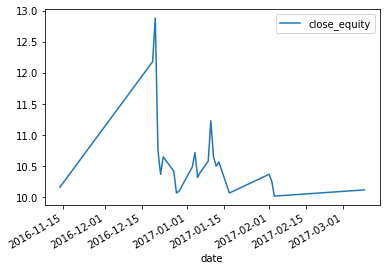

In [18]:
equity_data[equity_data['user_id'] == churn_id[6]].plot(x='date', y='close_equity')

> ***3. Equity Decreasing: this type of user equity tend to decrease gradually, which is shown below. This may be due to their 'limited_investment_experience', or may be due to their 'risk tolerance' or ect. In this case, we need to find out the relationship among 'investment_experience','risk tolerance', 'time_spent' ect.***

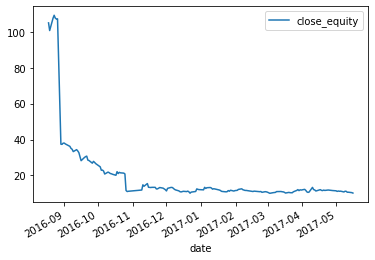

In [19]:
equity_data[equity_data['user_id'] == churn_id[15]].plot(x='date', y='close_equity')

> ***4. Transfer Money Out: This type of churned users' equity tend to increase over time. However, after a period of time, their equity drops below 10 dollars. This may be due to that that have earned their expected month or maybe they have short time_horizon, or they are possibly having long investment experience. We need to find out the relationship amont these features.***

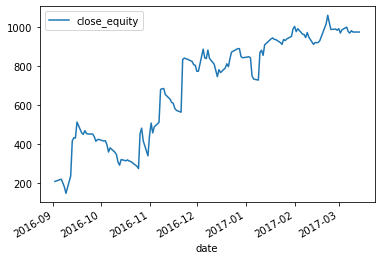

In [20]:
equity_data[equity_data['user_id'] == churn_id[17]].plot(x='date', y='close_equity')

# > ***3. Preprocess feature dataset.***

In [21]:
feature_data = pd.read_csv('../input/robinhood-data/features_data.csv') #Load feature dataset.

In [22]:
feature_data.head() #Read the first 5 rows of the dataset.

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91


In [23]:
active_days = equity_data.groupby('user_id')['date'].count() #The number of days with >= 10 dollar equity.

In [24]:
avg_equity = equity_data.groupby('user_id')['close_equity'].mean() #The average equity for each user.

In [25]:
df1 = pd.merge(feature_data, avg_equity, on='user_id')
df1

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,close_equity
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,77.118526
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,351.411468
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,49.240000
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,186.040280
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,208.753365
...,...,...,...,...,...,...,...,...,...,...
5579,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.339283,stock,300.0,long_time_horizon,03880c726d8a4e5db006afe4119ad974,2742.329510
5580,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,7.241383,stock,100.0,short_time_horizon,ae8315109657f44852b24c6bca4decd6,310.029010
5581,med_risk_tolerance,no_investment_exp,very_important_liq_need,both,22.967167,stock,50.0,short_time_horizon,f29c174989f9737058fe808fcf264135,116.134472
5582,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,10.338417,stock,100.0,long_time_horizon,24843497d1de88b2e7233f694436cb3a,330.172163


In [26]:
churned_user_dataset = pd.merge(df1, active_days, on='user_id')
churned_user_dataset

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,close_equity,date
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,77.118526,190
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,351.411468,252
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,49.240000,252
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,186.040280,143
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,208.753365,252
...,...,...,...,...,...,...,...,...,...,...,...
5579,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.339283,stock,300.0,long_time_horizon,03880c726d8a4e5db006afe4119ad974,2742.329510,252
5580,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,7.241383,stock,100.0,short_time_horizon,ae8315109657f44852b24c6bca4decd6,310.029010,99
5581,med_risk_tolerance,no_investment_exp,very_important_liq_need,both,22.967167,stock,50.0,short_time_horizon,f29c174989f9737058fe808fcf264135,116.134472,197
5582,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,10.338417,stock,100.0,long_time_horizon,24843497d1de88b2e7233f694436cb3a,330.172163,141


In [27]:
churned_user_dataset = churned_user_dataset.rename(columns={"date": "active_days", "close_equity": "avg_equity"})
churned_user_dataset

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,avg_equity,active_days
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,77.118526,190
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,351.411468,252
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,49.240000,252
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,186.040280,143
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,208.753365,252
...,...,...,...,...,...,...,...,...,...,...,...
5579,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.339283,stock,300.0,long_time_horizon,03880c726d8a4e5db006afe4119ad974,2742.329510,252
5580,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,7.241383,stock,100.0,short_time_horizon,ae8315109657f44852b24c6bca4decd6,310.029010,99
5581,med_risk_tolerance,no_investment_exp,very_important_liq_need,both,22.967167,stock,50.0,short_time_horizon,f29c174989f9737058fe808fcf264135,116.134472,197
5582,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,10.338417,stock,100.0,long_time_horizon,24843497d1de88b2e7233f694436cb3a,330.172163,141


In [ ]:
# pl = pd.get_dummies(churned_user_dataset.platform, prefix='platform')
# pd.concat([churned_user_dataset,pl], axis=1)

In [ ]:
# pd.get_dummies(churned_user_dataset, columns=['platform','investment_experience','risk_tolerance'])

In [ ]:
# churned_user_dataset.select_dtypes(include='number')

In [29]:
churned_user_dataset['churned'] = churned_user_dataset['user_id'].apply(lambda x: 1 if x in churn_id else 0) #Labeling target variable

# > ***4. Modeling.***

In [30]:
ID_col = ['user_id']
tar_col = ['churned']
num_cols = ['time_spent', 'first_deposit_amount','active_days','avg_equity']
cat_cols = list(set(list(churned_user_dataset.columns))-set(num_cols)-set(ID_col)-set(tar_col))
num_cat_cols = num_cols + cat_cols

In [31]:
for var in cat_cols:
    number = LabelEncoder()
    churned_user_dataset[var] = number.fit_transform(churned_user_dataset[var].astype('str')) #Convert categorical variables into numerical variables with label encoding.

In [32]:
#Define Evaluation Function

def eval_model(y_true,y_pred,labels):
    P,r,f1,s =precision_recall_fscore_support(y_true,y_pred)
    tot_P = np.average(P,weights =s)
    tot_r = np.average(r,weights =s)
    tot_f1 = np.average(f1,weights =s)
    tot_s = np.sum(s)
    res1 = pd.DataFrame({
        'Label':labels,
        'Precision':P,
        'Reacll':r,
        'F1':f1,
        'Support':s
    })
    res2 = pd.DataFrame({
        'Label':['Total'],
        'Precision':[tot_P],
        'Recall':[tot_r],
        'F1':[tot_f1],
        'Support':[tot_s]
    })
    res2.index=[999]
    res = pd.concat([res1,res2])
    conf_mat = pd.DataFrame(confusion_matrix(y_true,y_pred),columns=labels,index=labels)
    return conf_mat,res[['Label','Precision','Recall','F1','Support']]

In [33]:
X = churned_user_dataset.drop(columns=['user_id','churned']) #Independent variables
y = churned_user_dataset['churned'] #Dependent variable

In [39]:
y.unique()

array([0, 1])

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=44) #Seperate training and testing dataset.
#Logistic Regression Training Process X_train, X_val, y_train, y_val
model_lr = LogisticRegression(penalty ='l2',C=1,random_state=1234) 
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_val)
label_encoder = LabelEncoder()
conf_mat_lr,evalues_lr = eval_model(y_val,y_pred_lr,y.unique())

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


AttributeError: 'LabelEncoder' object has no attribute 'classes_'

# > ***5. Evaluation***

In [ ]:
conf_mat_lr

In [ ]:
evalues_lr

Question c): Based on my current current feature list and model, I would say the most important feature is 'user_equity' or 'avg_equity'.

In [ ]:
#apply SelectKBest class to extract top 5 best features
bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(5,'Score'))  #print 5 best features

# Summary:

> ***Lots of EDA graphs have been deleted on the final version concerning the running time. If further time given, I would dive into 1. each of the 4 types of churned users (mentioned above) and build models for each type individually. This will definitely assign more accurate probability number and improve classification accuracy eventually. Another part that I would dive into would be 2. feature engineering, some features play more important roles than others and there are even more features that can be discovered based on the current features. Last thing but not least, I would 3. detect and deal with outliers, as some users have extramely big number of time_spent and if we deal with that properly, we will have a better result. 
> (Note: 1. Since the given dataset looks complete and not with null values, so I wouldn't spend too much time on it. 2. Imbalanced Dataset: I tried different methods(oversampling, under sampling and SMOTE method) to address this issue, but the result does not look good.)***

Finally, I got F1 score around 0.92, which is a pretty good number. Thank you for your time for reading my tedious code 🙂 !